In [12]:
import os

import lpips
import torch as th
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2

from scripts import *

In [13]:
checkpoint_dir = "experiments/dataaug_all/lightning_logs/version_2/checkpoints/epoch=449.ckpt"
save_path = "experiments/ganinversion"

In [41]:
# load model
model = GAN.load_from_checkpoint(checkpoint_dir)
model.eval()
model.cuda()

GAN(
  (generator): BasicGenerator(
    (l1): Linear(in_features=100, out_features=4096, bias=True)
    (conv_blocks): Sequential(
      (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Upsample(scale_factor=2.0, mode=nearest)
      (2): ConvBlock(
        (conv_block): ModuleList(
          (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (3): Upsample(scale_factor=2.0, mode=nearest)
      (4): ConvBlock(
        (conv_block): ModuleList(
          (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (5): Upsample(scale_fac

In [42]:
# load cars
r, c = 32, 64
cars = np.load("../potsdam_data/potsdam_cars/cars.npy", allow_pickle=True)

cars_resized = []
for car in cars:
    car = cv2.cvtColor(car, cv2.COLOR_RGB2BGR)
    car_resized = cv2.resize(car, (c, r)).transpose(2, 0, 1).astype(np.float32)
    cars_resized.append(2*(car_resized / 255) - 1)

In [43]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
 
    def forward(self, x):
        return self.func(x)

# find best z vector
for param in model.generator.parameters():
    param.requires_grad = False
    
latent_dim =  model.generator.latent_dim
gan_inversion = nn.Sequential(nn.Linear(1, latent_dim, bias=False), 
                              Lambda(lambda x: x.reshape(1, latent_dim)),  
                              model.generator)

max_iterations = 900
x_orig = th.unsqueeze(th.tensor(cars_resized[0]), axis=0)
gan_inversion.cuda()
optimizer = th.optim.Adam(gan_inversion.parameters(), lr=1)
loss = lpips.LPIPS(net='vgg').cuda()

gan_inversion.train()
learning_curve= []
for i in range(max_iterations):
    
    optimizer.zero_grad()
    x_rec = gan_inversion.forward(th.ones(1).cuda())
    output = loss(x_orig.cuda(), x_rec)
    l = output.item()
    output.backward()
    optimizer.step()
    
    learning_curve.append(l)
    if i % 10 == 0:
        print("iteration ", i, "loss", l )
    
    if i % 90 == 0:
        for g in optimizer.param_groups:
            g['lr'] = g['lr']*0.1

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/hca/Documents/Master/Thesis/Master-Thesis/.env/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
iteration  0 loss 0.47334372997283936
iteration  10 loss 0.4974744915962219
iteration  20 loss 0.4751337468624115
iteration  30 loss 0.4556773602962494
iteration  40 loss 0.44263455271720886
iteration  50 loss 0.42834174633026123
iteration  60 loss 0.4114139676094055
iteration  70 loss 0.3983127176761627
iteration  80 loss 0.39094769954681396
iteration  90 loss 0.3849659562110901
iteration  100 loss 0.3838147819042206
iteration  110 loss 0.3831580579280853
iteration  120 loss 0.3824719190597534
iteration  130 loss 0.3818231225013733
iteration  140 loss 0.38121870160102844
iteration  150 loss 0.3806025981903076
iteration  160 loss 0.3800335228443146
iteration  170 loss 0.3794948160648346
iteration  180 loss 0.3789827227592468
iteration  190 loss 0.37887832522392273
iteration  200 loss 0.3788

([], [])

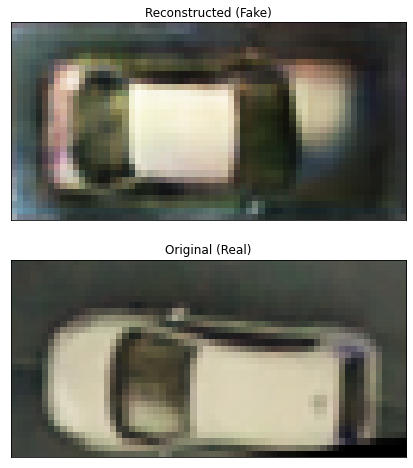

In [44]:
# rescale
x_rec_ = (np.squeeze(x_rec.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2
x_orig_ = (np.squeeze(x_orig.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2

# plot
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.imshow(x_rec_)
plt.title("Reconstructed (Fake)", fontsize=12)
plt.xticks([])
plt.yticks([])
plt.subplot(2, 1, 2)
plt.imshow(x_orig_)
plt.title("Original (Real)", fontsize=12)
plt.xticks([])
plt.yticks([])


In [1]:
# important params
checkpoint_dir = "experiments/dataaug/lightning_logs/version_1/checkpoints/epoch=774.ckpt"
save_path = "experiments/ganinversion/dataaug_version_1_epoch=774"

os.makedirs(save_path, exist_ok=True)

# optional
bs = 64
n_iter = 1000

NameError: name 'os' is not defined

In [ ]:
# load model
model = GAN.load_from_checkpoint(checkpoint_dir)
model.eval()
model.cuda()

In [4]:
# fake data loader
y_fake = []
X_fake = []

with th.no_grad():
    for i in range(10):
        z = th.normal(0, 1, (1000, model.hparams.latent_dim), device=model.device)
        x = model.generator(z)

        y_fake.append(z.detach().cpu())
        X_fake.append(x.detach().cpu())

y_fake = th.cat(y, axis=0).
X_fake = th.cat(X_fake, axis=0)

# save fake dataset
np.save(X_fake.detach().cpu().numpy(), os.path.join(save_path, "X_fake.npy"))
np.save(y.detach().cpu().numpy(), os.path.join(save_path, "y_fake.npy"))

dataset = TensorDataset(X_fake.detach().cpu(), y_fake.detach().cpu())
dataloader_fake = DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=2)

y_fake.shape, X_fake.shape

(torch.Size([10240, 100]), torch.Size([10240, 3, 32, 64]))

In [ ]:
# real data loader
r, c = 32, 64
cars = np.load("../potsdam_data/potsdam_cars/cars.npy", allow_pickle=True)

X_real = []
for car in cars:
    # car = cv2.cvtColor(car, cv2.COLOR_RGB2BGR)
    car_resized = cv2.resize(car, (c, r)).transpose(2, 0, 1).astype(np.float32)
    # for pytorch
    car_resized = car_resized.transpose(2, 0, 1)
    # scaling -1, 1
    car_resized = 2*(car_resized / 255) - 1
    
    # append
    X_real.append(X_real)
X_real = np.concatenate(X_real)

# save real dataset
np.save(X_real, os.path.join(save_path, "X_real.npy"))

X_real = th.tensor(X_real, dtype=X_fake.dtype)

dataset = TensorDataset(X_real, X_real)
dataloader_real = DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=2)

X_real.shape

In [ ]:
# val data loader
r, c = 32, 64
cars = np.load("../potsdam_data/potsdam_cars_val/cars.npy", allow_pickle=True)

X_real = []
for car in cars:
    # car = cv2.cvtColor(car, cv2.COLOR_RGB2BGR)
    car_resized = cv2.resize(car, (c, r)).transpose(2, 0, 1).astype(np.float32)
    # for pytorch
    car_resized = car_resized.transpose(2, 0, 1)
    # scaling -1, 1
    car_resized = 2*(car_resized / 255) - 1
    
    # append
    X_real.append(X_real)
X_real = np.concatenate(X_real)

# save real dataset
np.save(X_real, os.path.join(save_path, "X_real.npy"))

X_real = th.tensor(X_real, dtype=X_fake.dtype)

dataset = TensorDataset(X_real, X_real)
dataloader_val = DataLoader(dataset, batch_size=2*bs, shuffle=True, num_workers=2)

X_real.shape

In [5]:
class EncoderLatent(nn.Module):
    def __init__(self, generator):
        super().__init__()
        
        self.generator = generator
        for param in self.generator.parameters():
            param.requires_grad = False
        
        self.conv_blocks = nn.Sequential(
            ConvBlock(3, 32, bn_mode="default", use_bn=True),
            nn.MaxPool2d(2,2),
            ConvBlock(32, 64, bn_mode="default", use_bn=True),
            nn.MaxPool2d(2,2),
            ConvBlock(64, 128, bn_mode="default", use_bn=True),
            nn.MaxPool2d(2,2),
            ConvBlock(128, 256, bn_mode="default", use_bn=True),
            nn.MaxPool2d(2,2)
        )
        
        self.l1 = nn.Linear(2*4*256, 100)
    
    def forward(self, img):
        img = self.conv_blocks(img)
        img = img.view(img.shape[0], -1)
        z = self.l1(img)
        img_rec = self.generator(z)
        return z, img_rec

In [6]:
net = EncoderLatent().cuda()
optimizer = th.optim.Adam(net.parameters(), lr=0.001)
loss_latent = th.nn.MSELoss(reduction="mean")
loss_rec = th.nn.MSELoss(reduction="mean")

In [11]:
net.train()
learning_curve = []
n_iter = 1000

for i in range(n_iter):
    l = 0
    x_fake, z_fake = next(iter(dataloader_fake))
    x_real, _ = next(iter(dataloader_real))
    
    optimizer.zero_grad()
    z_fake_, x_fake_ = net.forward(x_fake.cuda())
    _, x_real_ = net.forward(x_real.cuda())


    loss_1 = loss_latent(z_fake_, z_fake.cuda())
    loss_2 = loss_rec(x_fake_, x_fake.cuda())
    loss_3 = loss_rec(x_real_, x_real.cuda())
    total_loss = loss_1 + loss_2 + loss_3
    l += total_loss.item()
    total_loss.backward()
    optimizer.step()
    
    learning_curve.append(l)
    if i % 10 == 0:
        print("iteration ", i, "loss", l)
    
    if i % 90 == 0:
        for g in optimizer.param_groups:
            g['lr'] = g['lr']*0.1
            
th.save(net.state_dict(), "experiments/gan_inversion/net.pkl")

iteration  10 loss 0.5701038524508476
iteration  20 loss 0.46596389785408976
iteration  30 loss 0.392927223443985
iteration  40 loss 0.3485002018511295
iteration  50 loss 0.3141316339373589
iteration  60 loss 0.28951241746544837
iteration  70 loss 0.26863467395305635
iteration  80 loss 0.25347248539328576
iteration  90 loss 0.23726159073412417
iteration  100 loss 0.19105645045638084
iteration  110 loss 0.18804034031927586
iteration  120 loss 0.18712375834584236
iteration  130 loss 0.1854029718786478
iteration  140 loss 0.184613586217165
iteration  150 loss 0.18307697661221028
iteration  160 loss 0.18208957985043525
iteration  170 loss 0.17833616212010384
iteration  180 loss 0.17727105058729647
iteration  190 loss 0.1712871503084898


Text(0, 0.5, 'MSE')

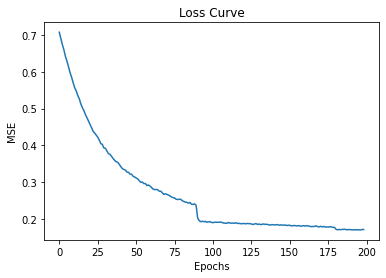

In [276]:
l = [ll / len(dataloader) for ll in learning_curve]
plt.plot(l)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE")

In [7]:
net.load_state_dict(th.load("experiments/gan_inversion/net.pkl"))
net.cuda()
net.eval()

EncoderLatent(
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (conv_block): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvBlock(
      (conv_block): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ConvBlock(
      (conv_block): ModuleList(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=0

([], [])

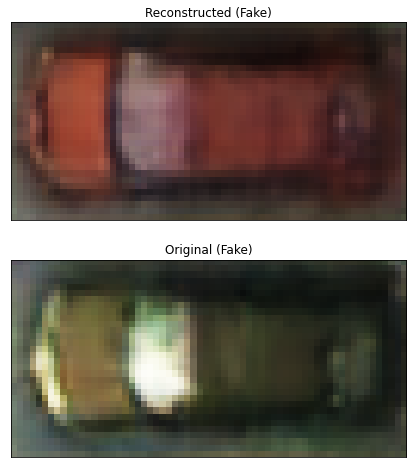

In [56]:
# testing
with th.no_grad():
    z = th.normal(0, 1, (1, model.hparams.latent_dim), device=model.device)
    x_orig = model.generator(z)

    z_rec = net.forward(x_orig)
    x_rec = model.generator(z_rec)

# rescale
x_rec = (np.squeeze(x_rec.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2
x_orig = (np.squeeze(x_orig.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2

# plot
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.imshow(x_rec)
plt.title("Reconstructed (Fake)", fontsize=12)
plt.xticks([])
plt.yticks([])
plt.subplot(2, 1, 2)
plt.imshow(x_orig)
plt.title("Original (Fake)", fontsize=12)
plt.xticks([])
plt.yticks([])

([], [])

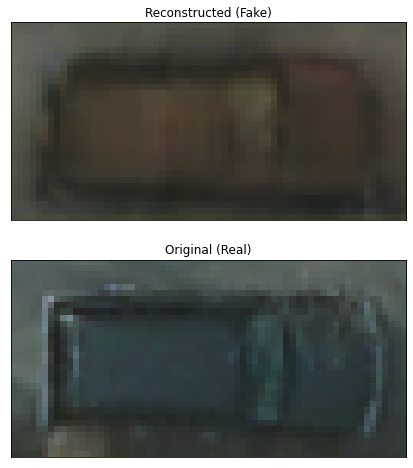

In [69]:
# real image
r, c = 32, 64
cars = np.load("../potsdam_data/potsdam_cars/cars.npy", allow_pickle=True)

cars_resized = []
for car in cars:
    # car = cv2.cvtColor(car, cv2.COLOR_RGB2BGR)
    car_resized = cv2.resize(car, (c, r)).transpose(2, 0, 1).astype(np.float32)
    cars_resized.append(2*(car_resized / 255) - 1)

i = 858
i = 4420
with th.no_grad():
    x_orig = th.unsqueeze(th.tensor(cars_resized[i]), axis=0)
    z_rec = net.forward(x_orig.cuda())
    x_rec = model.generator(z_rec)

# rescale
x_rec = (np.squeeze(x_rec.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2
x_orig = (np.squeeze(x_orig.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2

# plot
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.imshow(x_rec)
plt.title("Reconstructed (Fake)", fontsize=12)
plt.xticks([])
plt.yticks([])
plt.subplot(2, 1, 2)
plt.imshow(x_orig)
plt.title("Original (Real)", fontsize=12)
plt.xticks([])
plt.yticks([])